In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as  mpatches
import seaborn as sns
import pandas as pd
from labproject.metrics.wasserstein_sinkhorn import sinkhorn_loss,sinkhorn_algorithm
from labproject.metrics.wasserstein_kuhn import kuhn_transport
from labproject.metrics.sliced_wasserstein import sliced_wasserstein_distance
from labproject.metrics.MMD_torch import compute_rbf_mmd,median_heuristic
from labproject.data import get_distribution
from labproject.utils import set_seed
from dataclasses import dataclass
from torch.distributions import MultivariateNormal, Categorical
set_seed(0)



0

In [2]:
class MO2G:
    def __init__(self):
        self.means = torch.tensor(
            [
                [-3.0,1],
                [3, -1],

            ]
        )
        self.covariances = torch.tensor(
            [
                [[1.0, 0], [0, 1.0]],
                [[1.0, 0], [0, 1.0]]

            ]
        )
        self.weights = torch.tensor([0.2,0.8])

        # Create a list of 2D Gaussian distributions
        self.gaussians = [
            MultivariateNormal(mean, covariance)
            for mean, covariance in zip(self.means, self.covariances)
        ]

    def sample(self, sample_shape):
        if isinstance(sample_shape, int):
            sample_shape = (sample_shape,)
        # Sample from the mixture
        categorical = Categorical(self.weights)
        sample_indices = categorical.sample(sample_shape)
        return torch.stack([self.gaussians[i].sample() for i in sample_indices])

    def log_prob(self, input):
        probs = torch.stack([g.log_prob(input).exp() for g in self.gaussians])
        probs = probs.T * self.weights
        return torch.sum(probs, dim=1).log()



In [3]:
#Base distribution
from torch.distributions.multivariate_normal import MultivariateNormal
toy_data = get_distribution("toy_2d")
MOG = toy_data()
MOG = MO2G()
num_samples = 1000
mixture_samples =MOG.sample(num_samples)
mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)

/tmp/ipykernel_172762/39751654.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mixture_samples = torch.tensor(mixture_samples, dtype=torch.float32)


In [4]:
plt.style.use("../../matplotlibrc")


In [5]:
class Gauss(nn.Module):
    def __init__(self,dim):
        super(Gauss, self).__init__()
        self.mean = nn.Parameter(torch.zeros(dim))
        self._row_ix, self._column_ix = torch.tril_indices(dim,dim)
        # init_diag = torch.eye(dim)[self._row_ix, self._column_ix]
        init_diag = torch.ones(dim*(dim+1)//2)
        self.lower_triangular = nn.Parameter(init_diag.clone())
        self.dim = dim

    def forward(self, noise):
        sample = self.cov_lt().matmul(noise.transpose(-2,-1)).transpose(-2,-1) + self.mean.unsqueeze(0)
        return sample

    def sample(self,size):
        return self.forward(torch.randn(size, self.dim))

    def cov(self):
        return self.cov_lt().matmul(self.cov_lt().transpose(-2,-1))

    def cov_lt(self):
        cov = torch.zeros(self.dim,self.dim)
        cov[self._row_ix,self._column_ix] = self.lower_triangular
        return cov

    def log_prob(self, value):
        return MultivariateNormal(loc=self.mean, scale_tril=self.cov_lt()).log_prob(value)


In [6]:
10/1.77

5.649717514124294

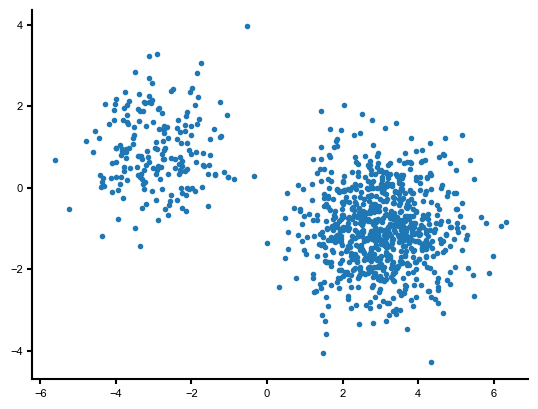

In [7]:
plt.scatter(mixture_samples[:, 0], mixture_samples[:, 1], label="Mixture of Gaussians")
covar = torch.cov(mixture_samples.T)
#plt.gca().set_box_aspect(1)


#make axis square

#plt.xlim()

In [8]:
def c2st_target(samples1, samples2, density1, density2):
    r"""Computes optimal C2ST and resulting classification cross-entropy loss
    for optimization
    """
    density_ratios1 = torch.stack([density1.log_prob(samples1), density2.log_prob(samples1)], dim=-1)
    density_ratios2 = torch.stack([density1.log_prob(samples2), density2.log_prob(samples2)], dim=-1)
    probs = torch.cat([density_ratios1, density_ratios2], dim=0)
    labels = torch.cat([torch.zeros(len(samples1)), torch.ones(len(samples2))], dim=0).long()
    loss = -nn.functional.cross_entropy(probs, labels)
    with torch.no_grad():
        c2st = (sum(density_ratios1[:, 0] >= density_ratios1[:, 1]) + sum(density_ratios2[:, 0] < density_ratios2[:, 1])) / (len(samples1) + len(samples2))
    return loss, c2st

In [9]:
gauss_model_C2ST = Gauss(2)

model_toy_opt = torch.optim.Adam(gauss_model_C2ST.parameters(), lr=0.01)

In [10]:
n_iters =2500
num_samples = 10000

for epoch in range(n_iters):
    model_toy_opt.zero_grad()

    model_samples = gauss_model_C2ST.sample(num_samples)
    toy_samples = MOG.sample(num_samples)

    cent_loss, true_c2st = c2st_target(model_samples, toy_samples, gauss_model_C2ST, MOG)
    # c2st_loss = torch.mean(torch.square(preds - 0.5))
    if epoch % 5 == 0:
        print("Iter: {}     loss: {}     c2st: {}".format(epoch, cent_loss.item(), true_c2st.item()))
    cent_loss.backward()
    model_toy_opt.step()

Iter: 0     loss: -0.08224739879369736     c2st: 0.9706500172615051
Iter: 5     loss: -0.10545195639133453     c2st: 0.9611499905586243
Iter: 10     loss: -0.12152279168367386     c2st: 0.95455002784729
Iter: 15     loss: -0.14192883670330048     c2st: 0.9445499777793884
Iter: 20     loss: -0.17288894951343536     c2st: 0.9326000213623047
Iter: 25     loss: -0.19721585512161255     c2st: 0.9206500053405762
Iter: 30     loss: -0.22355419397354126     c2st: 0.909500002861023
Iter: 35     loss: -0.2519991099834442     c2st: 0.8963500261306763
Iter: 40     loss: -0.27930524945259094     c2st: 0.8833000063896179
Iter: 45     loss: -0.31353577971458435     c2st: 0.864549994468689
Iter: 50     loss: -0.33012256026268005     c2st: 0.8575999736785889
Iter: 55     loss: -0.3582818806171417     c2st: 0.8432999849319458
Iter: 60     loss: -0.36819303035736084     c2st: 0.8367499709129333
Iter: 65     loss: -0.401350200176239     c2st: 0.8186500072479248
Iter: 70     loss: -0.40898460149765015     

In [11]:
# MMD
gauss_model_MMD = Gauss(dim=2)
with torch.no_grad():
    samples = gauss_model_MMD.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)
    bandwidth = median_heuristic(mixture_samples, uniform_samples)
    print("bandwidth: ", bandwidth)


bandwidth:  tensor(2.2888)


In [12]:

bandwidth = 1
optimizer = torch.optim.Adam(gauss_model_MMD.parameters(), lr=0.01)
gauss_model_MMD.train()

for epoch in range(n_iters):
    gauss_model_MMD.zero_grad()
    samples = gauss_model_MMD.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)    #print(samples)
    loss = compute_rbf_mmd(samples, uniform_samples, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model_MMD.eval()



Iter: 0     loss: 0.4496729373931885


Iter: 1     loss: 0.4451999068260193
Iter: 2     loss: 0.44188782572746277
Iter: 3     loss: 0.43756312131881714
Iter: 4     loss: 0.4393022656440735
Iter: 5     loss: 0.42359933257102966
Iter: 6     loss: 0.4275501072406769
Iter: 7     loss: 0.4198361039161682
Iter: 8     loss: 0.41872817277908325
Iter: 9     loss: 0.4192970395088196
Iter: 10     loss: 0.4064967930316925
Iter: 11     loss: 0.4023510813713074
Iter: 12     loss: 0.4011698067188263
Iter: 13     loss: 0.3993815779685974
Iter: 14     loss: 0.3897513151168823
Iter: 15     loss: 0.38918381929397583
Iter: 16     loss: 0.37855637073516846
Iter: 17     loss: 0.37639474868774414
Iter: 18     loss: 0.37560713291168213
Iter: 19     loss: 0.3692959249019623
Iter: 20     loss: 0.3607851266860962
Iter: 21     loss: 0.3593204915523529
Iter: 22     loss: 0.3562641739845276
Iter: 23     loss: 0.34850746393203735
Iter: 24     loss: 0.34767934679985046
Iter: 25     loss: 0.34617868065834045
Iter: 26     loss: 0.3355754315853119
Iter: 27  

Gauss()

In [13]:
# WS

gauss_model_WS = Gauss(dim=2)
optimizer = torch.optim.Adam(gauss_model_WS.parameters(), lr=0.01)
gauss_model_WS.train()
for epoch in range(n_iters):
    gauss_model_WS.zero_grad()
    samples = gauss_model_WS.sample(num_samples)
    uniform_samples = MOG.sample(num_samples)    #print(samples)
    loss = sliced_wasserstein_distance(samples, uniform_samples)#, bandwidth=bandwidth)
    print("Iter: {}     loss: {}".format(epoch, loss.item()))
    loss.backward()
    optimizer.step()

gauss_model_WS.eval()



Iter: 0     loss: 1.9805617332458496
Iter: 1     loss: 1.8025901317596436
Iter: 2     loss: 2.031694173812866
Iter: 3     loss: 1.9945542812347412
Iter: 4     loss: 1.7202919721603394
Iter: 5     loss: 1.7191053628921509
Iter: 6     loss: 1.9015761613845825
Iter: 7     loss: 1.7722537517547607
Iter: 8     loss: 1.854692816734314
Iter: 9     loss: 1.8887362480163574
Iter: 10     loss: 1.7506593465805054
Iter: 11     loss: 1.6440036296844482
Iter: 12     loss: 1.920646071434021
Iter: 13     loss: 1.7272852659225464
Iter: 14     loss: 1.6098318099975586
Iter: 15     loss: 1.658937931060791
Iter: 16     loss: 1.6579564809799194
Iter: 17     loss: 1.645857810974121
Iter: 18     loss: 1.5768449306488037
Iter: 19     loss: 1.803770661354065
Iter: 20     loss: 1.7684088945388794
Iter: 21     loss: 1.6124722957611084


Iter: 22     loss: 1.645538091659546
Iter: 23     loss: 1.6214109659194946
Iter: 24     loss: 1.6601475477218628
Iter: 25     loss: 1.6856441497802734
Iter: 26     loss: 1.5801130533218384
Iter: 27     loss: 1.630822777748108
Iter: 28     loss: 1.680274248123169
Iter: 29     loss: 1.4901219606399536
Iter: 30     loss: 1.5419976711273193
Iter: 31     loss: 1.5257341861724854
Iter: 32     loss: 1.3775995969772339
Iter: 33     loss: 1.476729154586792
Iter: 34     loss: 1.555536150932312
Iter: 35     loss: 1.3680497407913208
Iter: 36     loss: 1.4090090990066528
Iter: 37     loss: 1.498034954071045
Iter: 38     loss: 1.3738770484924316
Iter: 39     loss: 1.4740275144577026
Iter: 40     loss: 1.5475012063980103
Iter: 41     loss: 1.4163392782211304
Iter: 42     loss: 1.5104678869247437
Iter: 43     loss: 1.4174026250839233
Iter: 44     loss: 1.4191768169403076
Iter: 45     loss: 1.3937981128692627
Iter: 46     loss: 1.3800904750823975
Iter: 47     loss: 1.3861405849456787
Iter: 48     loss:

Gauss()

In [14]:
#FROM: https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
from matplotlib.patches import Ellipse

def plot_cov_ellipse(cov, pos, nstd=[1,2], ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    for std in nstd:
    # Width and height are "full" widths, not radius
        width, height = 2 * std * np.sqrt(vals)
        print(pos,width, height,theta)
        ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

        ax.add_artist(ellip)
    return ellip

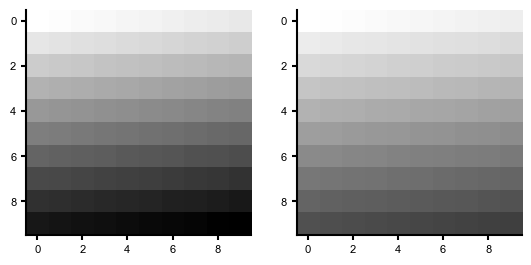

In [15]:
# FROM: https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
import matplotlib.colors as colors


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))
fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('gist_yarg')
new_cmap = truncate_colormap(cmap, 0, 0.75)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
plt.show()

[ 1.8006767 -0.5934437] 1.232063 0.5174054 161.3418
[ 1.8006767 -0.5934437] 2.464126 1.0348108 161.3418
[ 1.8006767 -0.5934437] 7.3923783 3.1044323 161.3418
[ 1.8006767 -0.5934437] 12.320631 5.174054 161.3418
[ 2.996361 -1.003967] 0.5963283 0.5839089 163.66649
[ 2.996361 -1.003967] 1.1926566 1.1678178 163.66649
[ 2.996361 -1.003967] 3.57797 3.5034535 163.66649
[ 2.996361 -1.003967] 5.963283 5.8390894 163.66649
[ 2.9978373 -1.0013971] 0.50547326 0.5018366 156.68369
[ 2.9978373 -1.0013971] 1.0109465 1.0036732 156.68369
[ 2.9978373 -1.0013971] 3.0328395 3.0110197 156.68369
[ 2.9978373 -1.0013971] 5.0547323 5.018366 156.68369


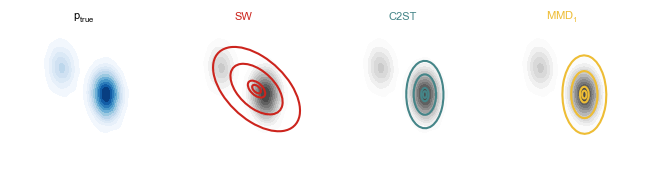

In [18]:
num_samples = 10000
#SWD_samples = gauss_model_WS.sample(num_samples).detach().numpy()
#MMD_samples = gauss_model_MMD.sample(num_samples).detach().numpy()
#C2ST_samples = gauss_model_C2ST.sample(num_samples).detach().numpy()

# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
#SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})
#MMD_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})
#C2ST_df = pd.DataFrame({'x': C2ST_samples[:, 0], 'y': MMD_samples[:, 1]})

# Plot the probability contours
fig,axs = plt.subplots(1,4, figsize = (6.5,3))
sns.kdeplot(ax=axs[0],data=unif_df, x='x', y='y',cmap="Blues", fill=True,levels=12)#, thresh=.1,)#, color="black",alpha=0.75, levels=5)

alpha_bg=1
sns.kdeplot(ax=axs[1],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)
sns.kdeplot(ax=axs[2],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)
sns.kdeplot(ax=axs[3],data=unif_df, x='x', y='y', fill=True,cmap=new_cmap,alpha=alpha_bg, levels=12)

#x, y = np.mgrid[-10:10:.1, -10:10:.1]
#z =torch.exp(gauss_model_WS.log_prob(data)).detach().numpy()
##axs[1].contour(x, y, z,colors ='#cc241d')#), cmap='coolwarm',fill=False)
##z =torch.exp(gauss_model_MMD.log_prob(data)).detach().numpy()
#axs[2].contour(x, y, z,colors ='#eebd35')#), cmap='coolwarm',fill=False)
#z =torch.exp(gauss_model_C2ST.log_prob(data)).detach().numpy()
#axs[3].contour(x, y, z,colors ="#458588")#), cmap='coolwarm',fill=False)
std_plot = [np.sqrt(.25),np.sqrt(.5),np.sqrt(1),np.sqrt(2)]
std_plot=[.25,.5,1.5,2.5]
plot_cov_ellipse(gauss_model_WS.cov().detach().numpy(),gauss_model_WS.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[1],edgecolor='#cc241d', lw=1.5, facecolor='none')
#axs[1].scatter(gauss_model_WS.mean.detach().numpy()[0],gauss_model_WS.mean.detach().numpy()[1],
#               color='#cc241d',s=1.5)
plot_cov_ellipse(gauss_model_MMD.cov().detach().numpy(),gauss_model_MMD.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[3],edgecolor='#eebd35', lw=1.5, facecolor='none')
plot_cov_ellipse(gauss_model_C2ST.cov().detach().numpy(),gauss_model_C2ST.mean.detach().numpy(),
                 nstd = std_plot ,ax=axs[2],edgecolor='#458588', lw=1.5, facecolor='none')

#sns.kdeplot(ax=axs[1],data=SWD_df, x='x', y='y', fill=False,cmap ="Reds",levels=7)#,color="#cc241d",alpha=.5, levels=5)
#sns.kdeplot(ax=axs[2],data=MMD_df, x='x', y='y', fill=False,cmap='Wistia',levels=7)#color="#eebd35",alpha=.5, levels=5)
#sns.kdeplot(ax=axs[3],data=C2ST_df, x='x', y='y', fill=False,cmap='Blues',levels=7)#color="#eebd35",alpha=.5, levels=5)
#color_dict = {"SW": "#cc241d", "MMD": "#eebd35", "C2ST": "#458588", "FID": "#8ec07c"}
#ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
#ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
for ax in axs:
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xlim(-8,5)
    ax.set_xlim(-10,10)

    ax.set_ylim(-7,4)
    #make square subplots 
    ax.set_box_aspect(1)
axs[0].set_title(r"$p_{true}$")
axs[1].set_title("SW",color ='#cc241d')
axs[3].set_title(r"$MMD_1$",color ='#eebd35')
axs[2].set_title("C2ST",color ="#458588")

fig.tight_layout()
plt.savefig("mode.pdf")

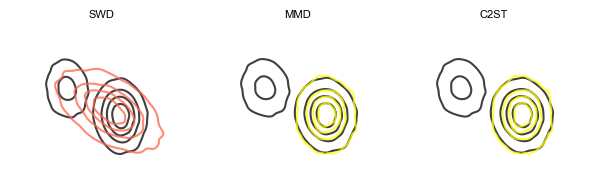

In [17]:
SWD_samples = gauss_model_WS.sample(num_samples).detach().numpy()
MMD_samples = gauss_model_MMD.sample(num_samples).detach().numpy()
C2ST_samples = gauss_model_C2ST.sample(num_samples).detach().numpy()

# Create a dataframe for the mixture samples
unif_df = pd.DataFrame({'x': uniform_samples[:, 0], 'y': uniform_samples[:, 1]})

# Create a dataframe for the SWD mixture samples
SWD_df = pd.DataFrame({'x': SWD_samples[:, 0], 'y': SWD_samples[:, 1]})
MMD_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})
C2ST_df = pd.DataFrame({'x': MMD_samples[:, 0], 'y': MMD_samples[:, 1]})

# Plot the probability contours
fig,axs = plt.subplots(1,3, figsize = (6,2))
sns.kdeplot(ax=axs[0],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[2],data=unif_df, x='x', y='y', fill=False, color="black",alpha=0.75, levels=5)

sns.kdeplot(ax=axs[0],data=SWD_df, x='x', y='y', fill=False, color="tomato",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[1],data=MMD_df, x='x', y='y', fill=False, color="yellow",alpha=0.75, levels=5)
sns.kdeplot(ax=axs[2],data=C2ST_df, x='x', y='y', fill=False, color="yellow",alpha=0.75, levels=5)

#ax.set_xlim(-1.5, 1.5)
#ax.set_ylim(-1.5, 1.5)
#ax.scatter(uniform_samples[:20, 0], uniform_samples[:20, 1], color="black",zorder=10)
#ax.scatter(SWD_samples[:20, 0], SWD_samples[:20, 1], color="coral",zorder=10)
for ax in axs:
    ax.spines[['left', 'bottom']].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
axs[0].set_title("SWD")
axs[1].set_title("MMD")
axs[2].set_title("C2ST")

fig.tight_layout()
